# Analyzing simulation results

Models to check:
- M1b
- M2a
- M2b
- M2c
- M2d
- M2b_w
- M4a
- M4b
- M4b_w

Results to 


Parameters to check:



In [1]:
import time
import tellurium as te
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('../')


## 1. Loading data

In [2]:
# loading patient data
patient_ids = np.loadtxt('../id_samples_3_cycles.txt', dtype=int)
blood_counts = pd.read_excel('../patient_data_venex/Ven_blood_counts_16042023.xlsx', sheet_name='Blood_counts')
bm_blasts = pd.read_excel('../patient_data_venex/Ven_blood_counts_16042023.xlsx', sheet_name='Bone_marrow_blasts')
cycle_days = pd.read_excel('../patient_data_venex/Ven_blood_counts_16042023.xlsx', sheet_name='Cycle_days')

# loading patient information
patient_data = pd.read_csv('../patient_data_venex/ven_responses_052023.txt', sep='\t')

### Load RMSE/param data for all models

In [3]:
m1b_param_data = pd.read_csv('../systematic_comparison_results_simplified_models/m1b_mp_param_data.csv', index_col=0)
m4a_param_data = pd.read_csv('../systematic_comparison_results_simplified_models/m4a_mp_param_data.csv', index_col=0)
m4b_param_data = pd.read_csv('../systematic_comparison_results_simplified_models/m4b_mp_param_data.csv', index_col=0)
m4b_wbc_only_param_data = pd.read_csv('../systematic_comparison_results_simplified_models/m4b_wbc_only_mp_param_data.csv', index_col=0)

m1b_rmse_data = pd.read_csv('../systematic_comparison_results_simplified_models/m1b_mp_rmse_data.csv', index_col=0)
m4a_rmse_data = pd.read_csv('../systematic_comparison_results_simplified_models/m4a_mp_rmse_data.csv', index_col=0)
m4b_rmse_data = pd.read_csv('../systematic_comparison_results_simplified_models/m4b_mp_rmse_data.csv', index_col=0)
m4b_wbc_only_rmse_data = pd.read_csv('../systematic_comparison_results_simplified_models/m4b_wbc_only_mp_rmse_data.csv', index_col=0)

In [4]:
m2a_param_data = pd.read_csv('../systematic_comparison_results_simplified_models/m2_2_param_data.csv', index_col=0)
m2b_param_data = pd.read_csv('../systematic_comparison_results_simplified_models/m2b_mp_param_data.csv', index_col=0)

m2a_rmse_data = pd.read_csv('../systematic_comparison_results_simplified_models/m2_2_rmse_data.csv', index_col=0)
m2b_rmse_data = pd.read_csv('../systematic_comparison_results_simplified_models/m2b_mp_rmse_data.csv', index_col=0)

In [5]:
m2c_param_data = pd.read_csv('../systematic_comparison_results_simplified_models/m2c_mp_param_data.csv', index_col=0)
m2c_rmse_data = pd.read_csv('../systematic_comparison_results_simplified_models/m2c_mp_rmse_data.csv', index_col=0)

m2d_param_data = pd.read_csv('../systematic_comparison_results_simplified_models/m2d_mp_param_data.csv', index_col=0)
m2d_rmse_data = pd.read_csv('../systematic_comparison_results_simplified_models/m2d_mp_rmse_data.csv', index_col=0)

m2b_wbc_only_rmse_data = pd.read_csv('../systematic_comparison_results_simplified_models/m2b_wbc_only_mp_rmse_data.csv', index_col=0)
m2b_wbc_only_param_data = pd.read_csv('../systematic_comparison_results_simplified_models/m2b_wbc_only_mp_param_data.csv', index_col=0)

In [6]:
m4c_param_data = pd.read_csv('../systematic_comparison_results_simplified_models/m4c_mp_param_data.csv', index_col=0)
m4c_rmse_data = pd.read_csv('../systematic_comparison_results_simplified_models/m4c_mp_rmse_data.csv', index_col=0)

## 2. Calculate fraction of variance unexplained

In [7]:
from new_patient_model import extract_data_from_tables_new

neut_variances = []
blast_variances = []
for patient_id in m4b_rmse_data.index:
    cycle_info_8013, leuk_table_8013, blast_table_8013 = extract_data_from_tables_new(blood_counts,
                                                                             bm_blasts, cycle_days, patient_id, use_neut=True)
    neut_variances.append(leuk_table_8013.b_neut.var())
    blast_variances.append(blast_table_8013.bm_blasts.var())

In [8]:
model_names = ['m1b', 'm4a', 'm4b', 'm4b_w', 'm4c', 'm2a', 'm2b', 'm2c', 'm2d', 'm2b_w']
model_params = [m1b_param_data, m4a_param_data, m4b_param_data, m4b_wbc_only_param_data,
                m4c_param_data,
                m2a_param_data, m2b_param_data, m2c_param_data, m2d_param_data, m2b_wbc_only_param_data,
                ]
model_rmses = [m1b_rmse_data, m4a_rmse_data, m4b_rmse_data, m4b_wbc_only_rmse_data,
               m4c_rmse_data,
               m2a_rmse_data, m2b_rmse_data, m2c_rmse_data, m2d_rmse_data, m2b_wbc_only_rmse_data,
               ]

#model_names = ['m4b_wbc_only', 'm2a', 'm2b', 'm2c', 'm2d', 'm2b_wbc_only']
#model_params = [m4b_wbc_only_param_data,
#                m2a_param_data, m2b_param_data, m2c_param_data, m2d_param_data, m2b_wbc_only_param_data,
#                ]
#model_rmses = [m4b_wbc_only_rmse_data,
#               m2a_rmse_data, m2b_rmse_data, m2c_rmse_data, m2d_rmse_data, m2b_wbc_only_rmse_data,
#               ]

In [9]:
# TODO: calculate frac unexplained variance using the 1 - r^2 formula
from systematic_model_comparisons_multiprocessing import MODELS
from new_patient_model import calculate_errors, build_pm_model_from_dataframes
from tellurium_model_fitting import rmse, get_model_results_times

data_neut_values = {}
model_neut_values = {}

for model_name, param_table, rmse_table in zip(model_names, model_params, model_rmses):
    print()
    print(model_name)
    print()
    model_neut_values[model_name] = []
    data_neut_values[model_name] = []
    model_functions = MODELS[model_name]
    model_desc = model_functions['model_desc']
    build_pm_model = model_functions['build_pm_model']
    initialization_fn = model_functions['initialization_fn']
    param_names = model_functions['param_names']
    param_bounds = model_functions['param_bounds']
    dosing_component = None
    if 'dosing_component' in model_functions:
        dosing_component = model_functions['dosing_component']
    use_blasts = True
    if 'wbc_only' in model_functions:
        use_blasts = not model_functions['wbc_only']
    neut_correlations = []
    blast_correlations = []
    # MAPE - mean absolute percentage error
    mape_neuts = []
    mape_blasts = []
    for patient_id, rmse_val in rmse_table.leuk_train.items():
        try:
            param_vals = param_table.loc[patient_id].to_list()
        except:
            print(patient_id, 'params not found')
            neut_correlations.append(np.inf)
            blast_correlations.append(np.inf)
            continue
        cycle_info, leuk_table, blast_table = extract_data_from_tables_new(blood_counts,
                                                                             bm_blasts, cycle_days, patient_id, use_neut=True)
        te_model, pm_model = build_pm_model_from_dataframes(cycle_info, leuk_table, blast_table,
            use_neut=True, use_b0=True,
            model_desc=model_desc,
            build_model_function=build_pm_model,
            initialization=initialization_fn,
            params_to_fit=param_names,
            dosing_component_function=dosing_component,
            uniform_prior=True,
            use_initial_guess=True,
            use_blasts=use_blasts
            )
        if np.isinf(rmse_val):
            print('rmse is inf')
            neut_correlations.append(np.inf)
            blast_correlations.append(np.inf)
            mape_neuts.append(np.inf)
            continue
        try:
            neut_corr, blast_corr, results = calculate_errors(te_model, param_vals, cycle_info, leuk_table, blast_table,
                                                   params_to_fit=param_names, wbc_only=not use_blasts, use_neut=True,
                                                   initialization=initialization_fn, error_fn='corrcoef')
        except:
            neut_corr = np.inf
            blast_corr = np.inf
            results = None
        neut_correlations.append(neut_corr)
        blast_correlations.append(blast_corr)
        if results is not None:
            results_points = get_model_results_times(results['Xwbc'], results['time'], leuk_table.lab_date.to_numpy())
            data_neut_values[model_name] += leuk_table.b_neut.to_list()
            model_neut_values[model_name] += results_points
            mape_neuts.append(rmse(results['Xwbc'], results['time'], leuk_table.b_neut.to_numpy(), leuk_table.lab_date.to_numpy(), 'mape'))
        else:
            mape_neuts.append(np.inf)
        #print('neut_corr:', neut_corr, 'blast_corr:', blast_corr)
    rmse_table['neut_corr'] = neut_correlations
    rmse_table['blast_corr'] = blast_correlations
    rmse_table['neut_mape'] = mape_neuts


m1b



/home/yzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning:

invalid value encountered in divide

/home/yzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning:

invalid value encountered in divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_n

rmse is inf


/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_mo


m4a



/home/yzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning:

invalid value encountered in divide

/home/yzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning:

invalid value encountered in divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide



rmse is inf


/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_mo


m4b



/home/yzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning:

invalid value encountered in divide

/home/yzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning:

invalid value encountered in divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide



rmse is inf


/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_mo


m4b_w

rmse is inf
rmse is inf


/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide



rmse is inf
rmse is inf


/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide



rmse is inf


/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide



rmse is inf
rmse is inf


/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide



rmse is inf


/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide



rmse is inf


/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide



rmse is inf
rmse is inf


/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide




m4c



/home/yzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning:

invalid value encountered in divide

/home/yzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning:

invalid value encountered in divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide



rmse is inf


/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_mo

rmse is inf


/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_mo


m2a



/home/yzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning:

invalid value encountered in divide

/home/yzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning:

invalid value encountered in divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_n


m2b



/home/yzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning:

invalid value encountered in divide

/home/yzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning:

invalid value encountered in divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_n


m2c



/home/yzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning:

invalid value encountered in divide

/home/yzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning:

invalid value encountered in divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide



rmse is inf


/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_mo


m2d



/home/yzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning:

invalid value encountered in divide

/home/yzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning:

invalid value encountered in divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide



rmse is inf


/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_mo

rmse is inf


/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide




m2b_w



/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide



rmse is inf


/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_modeling/publication_notebooks_revision/../tellurium_model_fitting.py:45: RuntimeWarning:

divide by zero encountered in scalar divide

/home/yzhang/aml_toxicity_mo

In [10]:
for model_rmse in model_rmses:
    model_rmse['neut_corr_2'] = model_rmse['neut_corr']
    model_rmse['blast_corr_2'] = model_rmse['blast_corr']
    model_rmse.loc[model_rmse['neut_corr'] < 0, 'neut_corr_2'] = 0
    model_rmse.loc[model_rmse['blast_corr'] < 0, 'blast_corr_2'] = 0
    model_rmse['neut_fvu_r2'] = 1 - model_rmse['neut_corr_2']**2
    model_rmse['blast_fvu_r2'] = 1 - model_rmse['blast_corr_2']**2
    # different method of calculating FVU
    model_rmse['frac_unexplained_variance_neut'] = model_rmse.leuk_train**2/neut_variances
    model_rmse['frac_unexplained_variance_blast'] = model_rmse.blasts_train**2/blast_variances
    # MAPE - 

### Combining data tables

In [11]:
m1b_rmse_data['model'] = 'm1'
m4a_rmse_data['model'] = 'm1a'
m4b_rmse_data['model'] = 'm1b'
m4b_wbc_only_rmse_data['model'] = 'm1b_w'
m4c_rmse_data['model'] = 'm1c'
m2a_rmse_data['model'] = 'm2a'
m2b_rmse_data['model'] = 'm2b'

m2c_rmse_data['model'] = 'm2c'
m2d_rmse_data['model'] = 'm2d'
m2b_wbc_only_rmse_data['model'] = 'm2b_w'

rmse_data_combined = pd.concat([m1b_rmse_data, m4a_rmse_data, m4b_rmse_data, m4b_wbc_only_rmse_data,
                                m4c_rmse_data,
                                m2a_rmse_data, m2b_rmse_data, m2b_wbc_only_rmse_data, m2c_rmse_data, m2d_rmse_data])

### Saving output table

In [12]:
rmse_data_combined.to_csv('rmse_data_combined_table_2025_05_01.csv')

### Combined plot of all model vs data results

Text(0, 0.5, 'Model neutrophil counts')

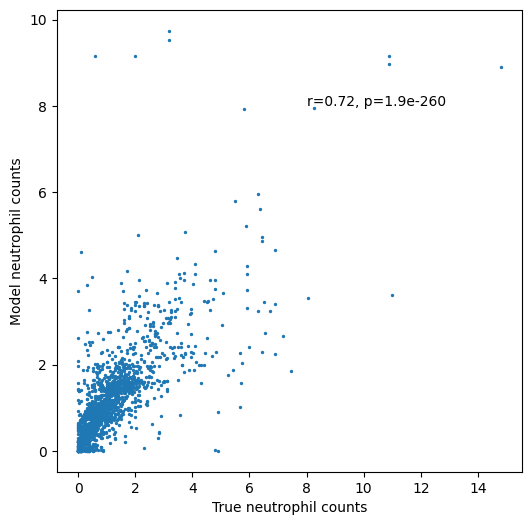

In [13]:
# TODO: plot correlations for each model
rr = scipy.stats.pearsonr(data_neut_values['m2c'], model_neut_values['m2c'])
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(data_neut_values['m2c'], model_neut_values['m2c'], s=2)
ax.text(8, 8, 'r={:.2f}, p={:.2g}'.format(rr.statistic, rr.pvalue))
ax.set_xlabel('True neutrophil counts')
ax.set_ylabel('Model neutrophil counts')

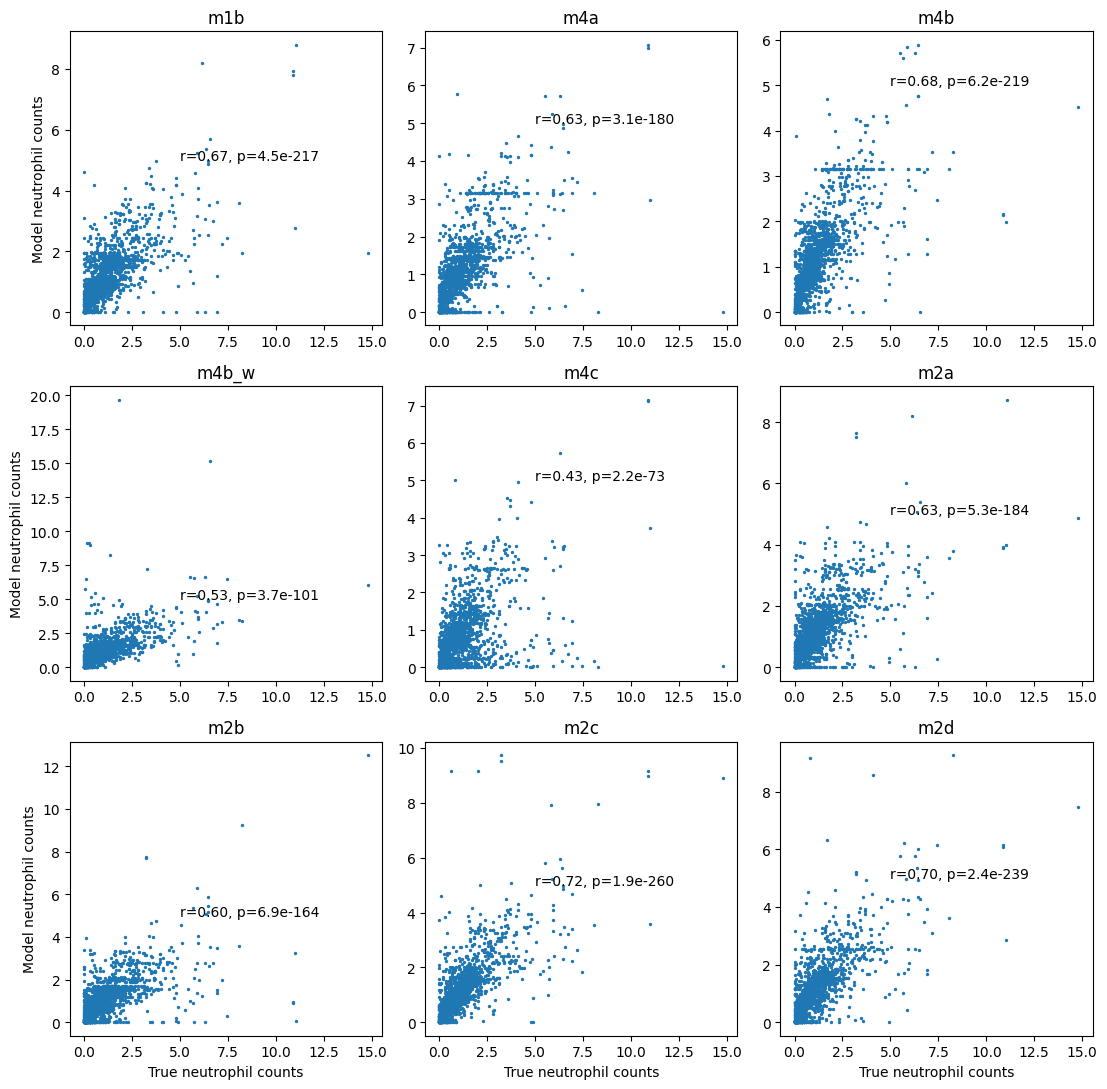

In [14]:
fig, axes = plt.subplots(3, 3, figsize=(11, 11))
#fig.delaxes(axes[1, 3])
axes = axes.flatten()
#axes = axes[:-1]
for i, ax in enumerate(axes):
    model_name = model_names[i]
    rr = scipy.stats.pearsonr(data_neut_values[model_name], model_neut_values[model_name])
    ax.scatter(data_neut_values[model_name], model_neut_values[model_name], s=2)
    ax.text(5, 5, 'r={:.2f}, p={:.2g}'.format(rr.statistic, rr.pvalue))
    ax.set_title(model_name)
axes[0].set_ylabel('Model neutrophil counts')
axes[3].set_ylabel('Model neutrophil counts')
axes[6].set_ylabel('Model neutrophil counts')
axes[6].set_xlabel('True neutrophil counts')
axes[7].set_xlabel('True neutrophil counts')
axes[8].set_xlabel('True neutrophil counts')
plt.tight_layout()
plt.savefig('supp_fig_predicted_vs_true_neutrophils.png', dpi=300)

Text(0, 0.5, 'Model neutrophil counts')

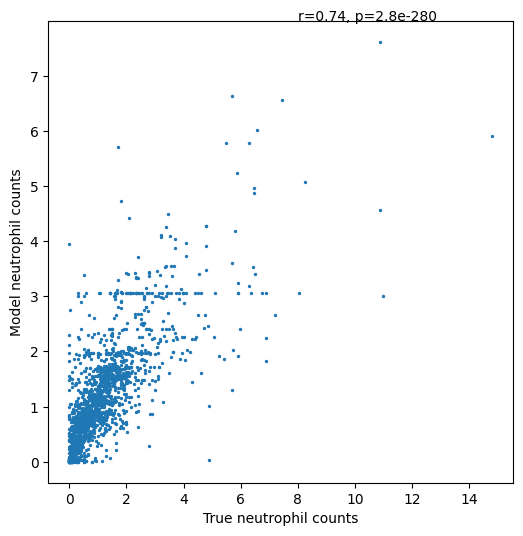

In [15]:
rr = scipy.stats.pearsonr(data_neut_values['m2b_w'], model_neut_values['m2b_w'])
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(data_neut_values['m2b_w'], model_neut_values['m2b_w'], s=2)
ax.text(8, 8, 'r={:.2f}, p={:.2g}'.format(rr.statistic, rr.pvalue))
ax.set_xlabel('True neutrophil counts')
ax.set_ylabel('Model neutrophil counts')

## 3. Comparing Fraction of variance unexplained across models

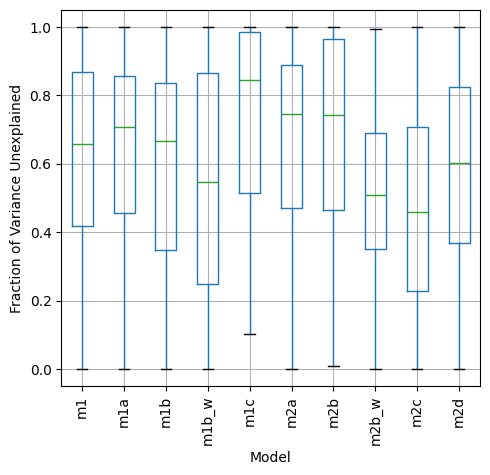

In [16]:
#model_names_ticks = ['m1b', 'm2a', 'm2b', 'm2b_w', 'm2c', 'm2d', 'm4a', 'm4b', 'm4b_w']
fig, ax = plt.subplots(figsize=(5, 5))
ax = rmse_data_combined.boxplot('neut_fvu_r2', by='model', ax=ax)
plt.ylabel('Fraction of Variance Unexplained')
plt.xlabel('Model')
ax.tick_params(axis='x', rotation=90)
#ax.xticks = model_names_ticks
ax.set_title('')
fig = ax.get_figure()
fig.suptitle('')
plt.tight_layout()
plt.savefig('fig1c.png', dpi=300)

In [17]:
rmse_data_combined.groupby('model').neut_fvu_r2.aggregate('median')

model
m1       0.659414
m1a      0.707527
m1b      0.666216
m1b_w    0.547917
m1c      0.844029
m2a      0.746871
m2b      0.742289
m2b_w    0.508067
m2c      0.458086
m2d      0.603876
Name: neut_fvu_r2, dtype: float64

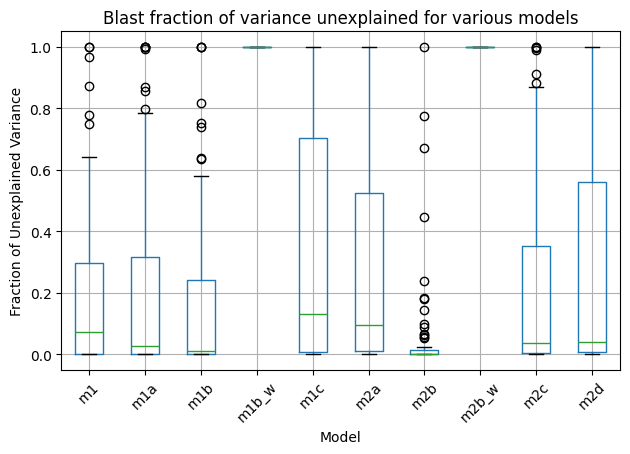

In [18]:
ax = rmse_data_combined.boxplot('blast_fvu_r2', by='model')
plt.ylabel('Fraction of Unexplained Variance')
plt.xlabel('Model')
ax.tick_params(axis='x', rotation=45)
ax.set_title('Blast fraction of variance unexplained for various models')
fig = ax.get_figure()
fig.suptitle('')
plt.tight_layout()
plt.savefig('fig1c_blast.png', dpi=300)

### Different methods of calculating model error

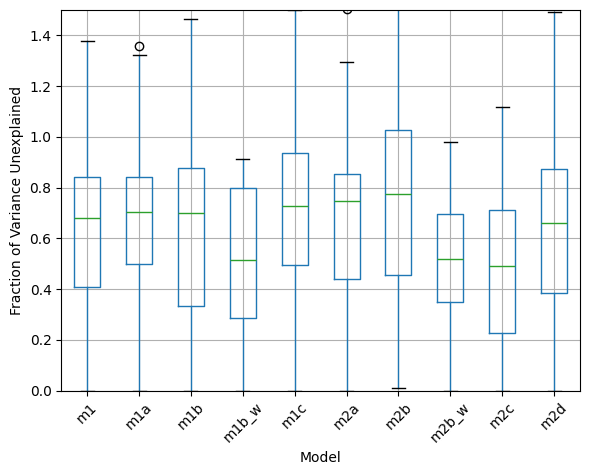

In [19]:
fig, ax = plt.subplots(figsize=(6, 5))
ax = rmse_data_combined.boxplot('frac_unexplained_variance_neut', by='model', ax=ax)
plt.ylabel('Fraction of Variance Unexplained')
plt.ylim(0, 1.5)
plt.xlabel('Model')
ax.tick_params(axis='x', rotation=45)
ax.set_title('')
fig = ax.get_figure()
fig.suptitle('')
plt.tight_layout()
plt.savefig('fig1c_fvu_mse_neut.png', dpi=300)

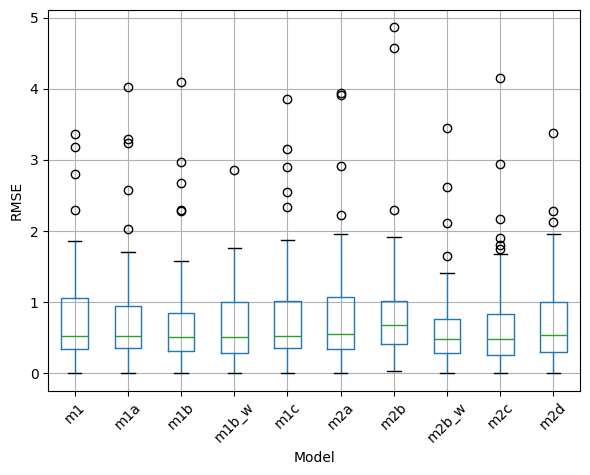

In [20]:
fig, ax = plt.subplots(figsize=(6, 5))
ax = rmse_data_combined.boxplot('leuk_train', by='model', ax=ax)
plt.ylabel('RMSE')
plt.xlabel('Model')
ax.tick_params(axis='x', rotation=45)
ax.set_title('')
fig = ax.get_figure()
fig.suptitle('')
plt.tight_layout()
plt.savefig('fig1c_rmse_neut.png', dpi=300)

In [21]:
rmse_data_combined.groupby('model').leuk_train.aggregate('median')

model
m1       0.529148
m1a      0.528718
m1b      0.506377
m1b_w    0.510921
m1c      0.525529
m2a      0.552891
m2b      0.684099
m2b_w    0.488381
m2c      0.477374
m2d      0.537193
Name: leuk_train, dtype: float64

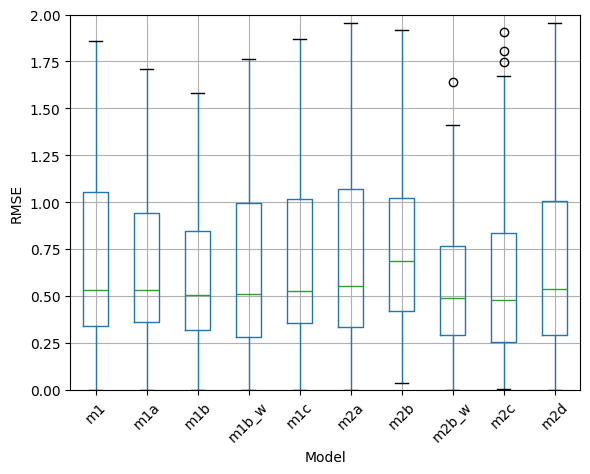

In [22]:
fig, ax = plt.subplots(figsize=(6, 5))
ax = rmse_data_combined.boxplot('leuk_train', by='model', ax=ax)
plt.ylabel('RMSE')
plt.xlabel('Model')
ax.tick_params(axis='x', rotation=45)
ax.set_title('')
ax.set_ylim(0, 2)
fig = ax.get_figure()
fig.suptitle('')
plt.tight_layout()
plt.savefig('fig1c_cut_rmse_neut.png', dpi=300)

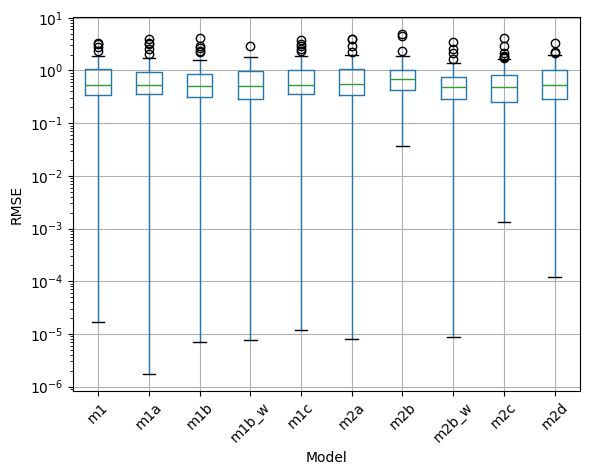

In [23]:
fig, ax = plt.subplots(figsize=(6, 5))
ax = rmse_data_combined.boxplot('leuk_train', by='model', ax=ax)
ax.set_yscale('log')
plt.ylabel('RMSE')
plt.xlabel('Model')
ax.tick_params(axis='x', rotation=45)
ax.set_title('')
fig = ax.get_figure()
fig.suptitle('')
plt.tight_layout()
plt.savefig('fig1c_log_rmse_neut.png', dpi=300)

/home/yzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning:

invalid value encountered in subtract

/home/yzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/matplotlib/cbook.py:1320: RuntimeWarning:

invalid value encountered in less_equal

/home/yzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/matplotlib/cbook.py:1327: RuntimeWarning:

invalid value encountered in greater_equal

/home/yzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/matplotlib/cbook.py:1336: RuntimeWarning:

invalid value encountered in greater



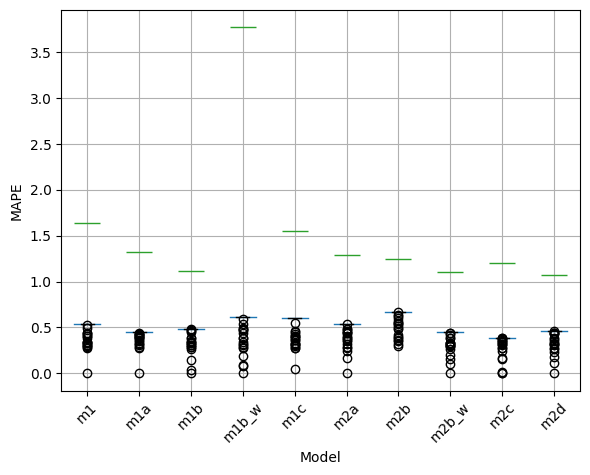

In [24]:
fig, ax = plt.subplots(figsize=(6, 5))
ax = rmse_data_combined.boxplot('neut_mape', by='model', ax=ax)
plt.ylabel('MAPE')
plt.xlabel('Model')
ax.tick_params(axis='x', rotation=45)
ax.set_title('')
fig = ax.get_figure()
fig.suptitle('')
plt.tight_layout()
plt.savefig('fig1c_mape_neut.png', dpi=300)

### Heatmap of FVU across all patients and models

This recapitulates the information present in Figure 1c but in more detail.

In [25]:
fvu_array = rmse_data_combined.pivot(columns='model', values='neut_fvu_r2')

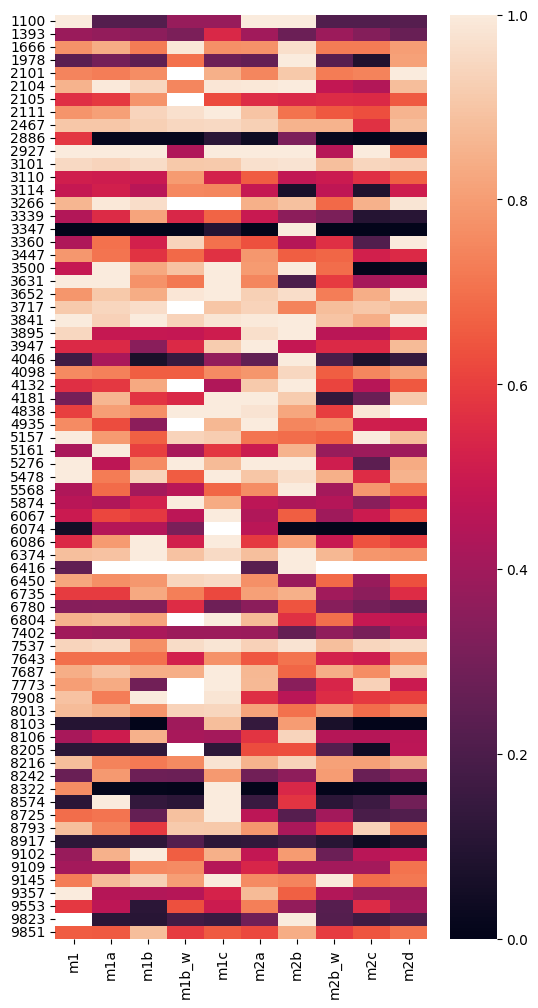

In [26]:
fig, ax = plt.subplots(figsize=(6, 12))
ax = sns.heatmap(fvu_array.values, xticklabels=fvu_array.columns, yticklabels=fvu_array.index, ax=ax, vmin=0, vmax=1)

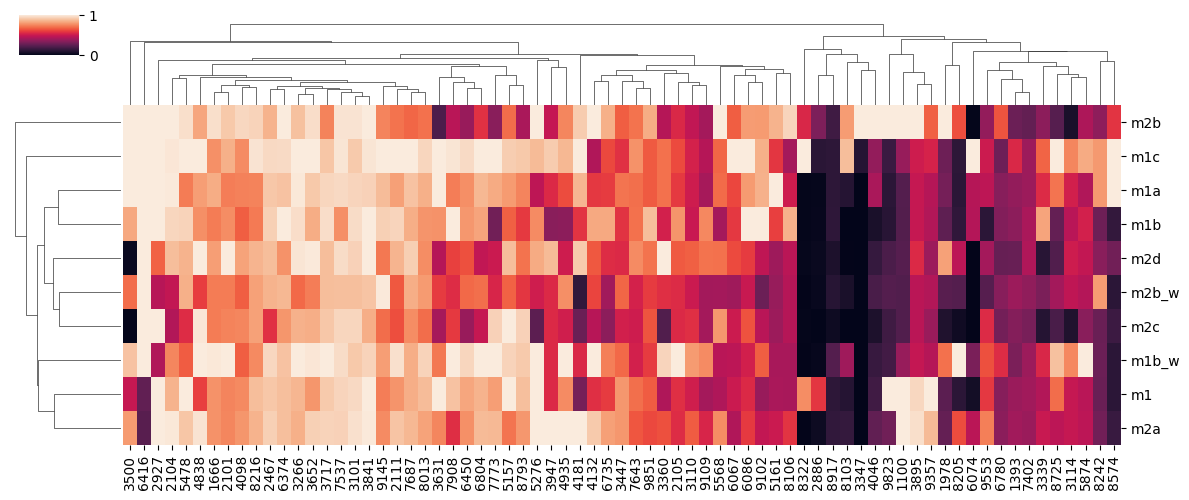

In [27]:
fvu_array_no_infs = fvu_array.replace(np.inf, 1)
fvu_array_no_infs = fvu_array.replace(-np.inf, 1)

#fig, ax = plt.subplots(figsize=(5, 12))
clustergrid = sns.clustermap(fvu_array_no_infs.values.T, xticklabels=fvu_array.index, yticklabels=fvu_array.columns, vmin=0, vmax=1, 
                             figsize=(12, 5),
                   cbar_pos=(0.02, 0.9, 0.05, 0.08),
                   dendrogram_ratio=(0.1, 0.2), 
                   )
#plt.tight_layout()
plt.savefig('fig1_model_patient_fvu_heatmap.png', dpi=300)

### Heatmap of RMSE across all patients and models

In [28]:
rmse_array = rmse_data_combined.pivot(columns='model', values='leuk_train')

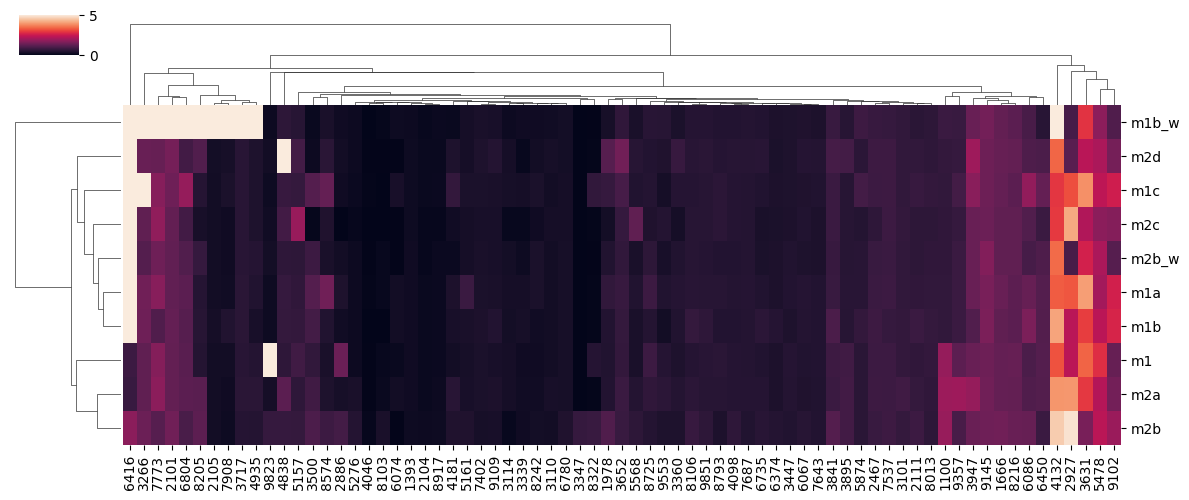

In [29]:
rmse_array_no_infs = rmse_array.replace(np.inf, 5)
rmse_array_no_infs = rmse_array_no_infs.replace(-np.inf, 5)

#fig, ax = plt.subplots(figsize=(5, 12))
clustergrid = sns.clustermap(rmse_array_no_infs.values.T, xticklabels=rmse_array.index, yticklabels=rmse_array.columns,
                             vmin=0, vmax=5, 
                             figsize=(12, 5),
                   cbar_pos=(0.02, 0.9, 0.05, 0.08),
                   dendrogram_ratio=(0.1, 0.2), 
                   )
#plt.tight_layout()
plt.savefig('fig1_model_patient_rmse_heatmap.png', dpi=300)

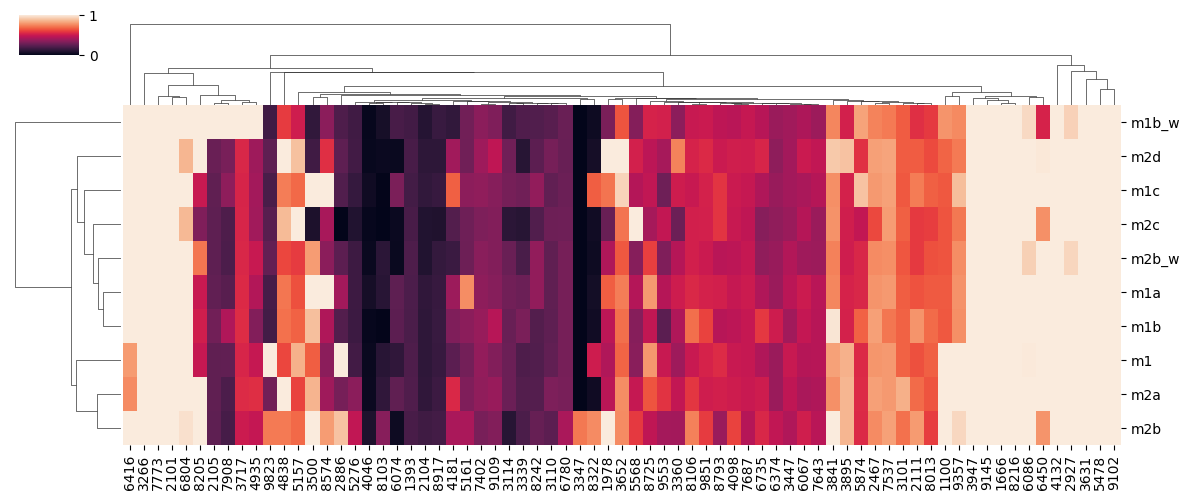

In [30]:
clustergrid = sns.clustermap(rmse_array_no_infs.values.T, xticklabels=rmse_array.index, yticklabels=rmse_array.columns,
                             vmin=0, vmax=1, 
                             figsize=(12, 5),
                   cbar_pos=(0.02, 0.9, 0.05, 0.08),
                   dendrogram_ratio=(0.1, 0.2), 
                   )
#plt.tight_layout()
plt.savefig('fig1_model_patient_rmse_heatmap.png', dpi=300)

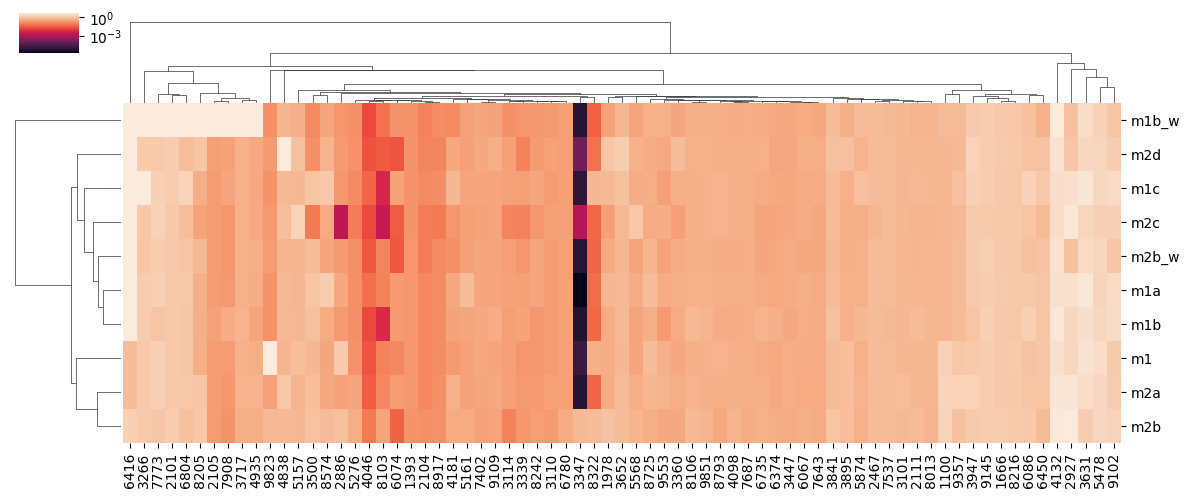

In [31]:
from matplotlib.colors import LogNorm, Normalize

clustergrid = sns.clustermap(rmse_array_no_infs.values.T, xticklabels=rmse_array.index, yticklabels=rmse_array.columns,
                             vmin=0, vmax=5,
                             norm=LogNorm(),
                             figsize=(12, 5),
                   cbar_pos=(0.02, 0.9, 0.05, 0.08),
                   dendrogram_ratio=(0.1, 0.2), 
                   )
#plt.tight_layout()
plt.savefig('fig1_model_patient_rmse_heatmap.png', dpi=300)

## 4. Statistical hypothesis testing for FVU differences between models

In [32]:
models = ['m1', 'm1a', 'm1b', 'm1b_w', 'm1c', 'm2a', 'm2b', 'm2b_w', 'm2c', 'm2d', ]
model_pval_results = {}
for m1 in models:
    m1_data = rmse_data_combined[rmse_data_combined.model==m1].neut_fvu_r2
    m1_data_index = m1_data.index[~np.isinf(m1_data)]
    for m2 in models:
        if m1 == m2:
            continue
        m2_data = rmse_data_combined[rmse_data_combined.model==m2].neut_fvu_r2
        m2_data_index = m2_data.index[~np.isinf(m2_data)]
        c_index = m1_data_index.intersection(m2_data_index)
        diff = (m1_data[c_index] - m2_data[c_index]).median()
        stat, pval = scipy.stats.wilcoxon(m1_data[c_index], m2_data[c_index])
        one_sided_stat, one_sided_pval = scipy.stats.wilcoxon(m1_data[c_index], m2_data[c_index], alternative='less')
        print(m1, m2, stat, one_sided_pval)
        model_pval_results[m1, m2] = {'median_diff': diff, 'stat': stat, 'pval': pval, 'one_sided_pval': one_sided_pval}

m1 m1a 974.0 0.15134157113827623
m1 m1b 1142.0 0.5751185502660183
m1 m1b_w 756.0 0.1651055149743751
m1 m1c 446.0 3.557937234852487e-05
m1 m2a 774.0 0.007383752873315173
m1 m2b 960.0 0.0965427767983319
m1 m2b_w 348.0 0.999999861827513
m1 m2c 329.0 0.9999997901331382
m1 m2d 972.0 0.8903104950288296
m1a m1 974.0 0.8486584288617238
m1a m1b 960.0 0.930535246505543
m1a m1b_w 882.0 0.4040286895421993
m1a m1c 331.0 1.0610181585461237e-06
m1a m2a 1042.0 0.16120546607532876
m1a m2b 1039.0 0.20645386959284773
m1a m2b_w 306.0 0.9999999788019965
m1a m2c 306.0 0.9999999647751022
m1a m2d 939.0 0.9457912793974077
m1b m1 1142.0 0.4248814497339817
m1b m1a 960.0 0.06946475349445698
m1b m1b_w 743.0 0.1027215103986554
m1b m1c 429.0 7.747304326116076e-06
m1b m2a 871.0 0.022114425672178823
m1b m2b 853.0 0.025273061910887122
m1b m2b_w 693.0 0.9993495346022696
m1b m2c 542.0 0.9999653954975463
m1b m2d 1121.0 0.6246583027896689
m1b_w m1 756.0 0.8348944850256249
m1b_w m1a 882.0 0.5959713104578007
m1b_w m1b 743.0 

In [33]:
pval_array = np.zeros((len(models), len(models)))
diff_array = np.zeros((len(models), len(models)))
for i, m1 in enumerate(models):
    for j, m2 in enumerate(models):
        if m1 == m2:
            pval_array[i, j] = 1
            diff_array[i, j] = 0
        else:
            pval_array[i, j] = model_pval_results[m1, m2]['one_sided_pval']
            diff_array[i, j] = model_pval_results[m1, m2]['median_diff']

In [34]:
pval_array_fdr = scipy.stats.false_discovery_control(pval_array.flatten())

In [35]:
pval_array_fdr = pval_array_fdr.reshape(pval_array.shape)

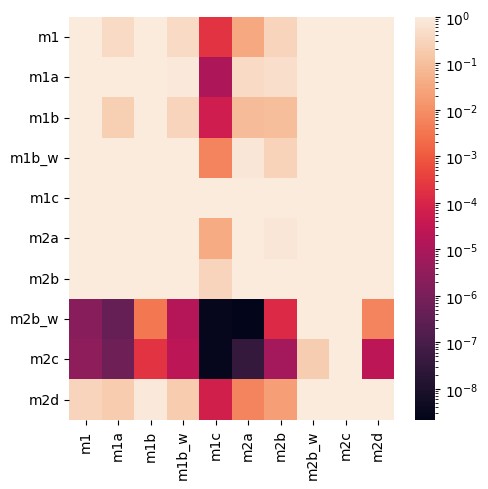

In [36]:
from matplotlib.colors import LogNorm

#sns.heatmap(pval_array, xticklabels=models, yticklabels=models, annot=pval_array_fdr,  norm=LogNorm())
fig, ax = plt.subplots(figsize=(5, 5))
ax = sns.heatmap(pval_array_fdr, xticklabels=models, yticklabels=models, norm=LogNorm(), ax=ax)
ax.tick_params(axis='y', rotation=0)
#ax.set_title('FDR values for FVU comparisons of different models')
plt.tight_layout()
plt.savefig('fig1d.png', dpi=300)

### Statistical hypothesis testing for RMSE differences between models

In [37]:
models = ['m1', 'm1a', 'm1b', 'm1b_w', 'm1c', 'm2a', 'm2b', 'm2b_w', 'm2c', 'm2d']
model_pval_results = {}
for m1 in models:
    m1_data = rmse_data_combined[rmse_data_combined.model==m1].leuk_train
    m1_data_index = m1_data.index[~np.isinf(m1_data)]
    for m2 in models:
        if m1 == m2:
            continue
        m2_data = rmse_data_combined[rmse_data_combined.model==m2].leuk_train
        m2_data_index = m2_data.index[~np.isinf(m2_data)]
        c_index = m1_data_index.intersection(m2_data_index)
        diff = (m1_data[c_index] - m2_data[c_index]).median()
        stat, pval = scipy.stats.wilcoxon(m1_data[c_index], m2_data[c_index])
        one_sided_stat, one_sided_pval = scipy.stats.wilcoxon(m1_data[c_index], m2_data[c_index], alternative='less')
        print(m1, m2, stat, one_sided_pval)
        model_pval_results[m1, m2] = {'median_diff': diff, 'stat': stat, 'pval': pval, 'one_sided_pval': one_sided_pval}

m1 m1a 948.0 0.060386574794950125
m1 m1b 1165.0 0.39970713565922167
m1 m1b_w 185.0 0.9999999366593487
m1 m1c 938.0 0.07551069349625748
m1 m2a 756.0 0.0022060662016006338
m1 m2b 852.0 0.011148286146982959
m1 m2b_w 417.0 0.9999988570822729
m1 m2c 543.0 0.9999645149418611
m1 m2d 1151.0 0.4465321591113562
m1a m1 948.0 0.9396134252050499
m1a m1b 996.0 0.9254281960230762
m1a m1b_w 162.0 0.9999999851577194
m1a m1c 1206.0 0.49642216623455665
m1a m2a 1061.0 0.14407899816069053
m1a m2b 990.0 0.06974724561529326
m1a m2b_w 365.0 0.9999998591455447
m1a m2c 466.0 0.9999972430451185
m1a m2d 1096.0 0.7475029421400243
m1b m1 1165.0 0.6002928643407783
m1b m1a 996.0 0.07457180397692378
m1b m1b_w 328.0 0.9999922429970408
m1b m1c 863.0 0.01971136626121764
m1b m2a 1044.0 0.12268715532398594
m1b m2b 838.0 0.00896143154185478
m1b m2b_w 702.0 0.9992195191113415
m1b m2c 632.0 0.9998233790683297
m1b m2d 1183.0 0.5582304131862742
m1b_w m1 185.0 6.334065131224472e-08
m1b_w m1a 162.0 1.4842280627499922e-08
m1b_w m1

In [38]:
pval_array = np.zeros((len(models), len(models)))
diff_array = np.zeros((len(models), len(models)))
for i, m1 in enumerate(models):
    for j, m2 in enumerate(models):
        if m1 == m2:
            pval_array[i, j] = 1
            diff_array[i, j] = 0
        else:
            pval_array[i, j] = model_pval_results[m1, m2]['one_sided_pval']
            diff_array[i, j] = model_pval_results[m1, m2]['median_diff']

In [39]:
pval_array_fdr = scipy.stats.false_discovery_control(pval_array.flatten())

In [40]:
pval_array_fdr = pval_array_fdr.reshape(pval_array.shape)

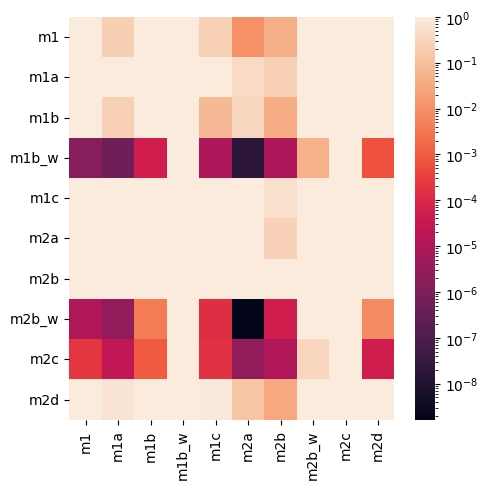

In [41]:
from matplotlib.colors import LogNorm

#sns.heatmap(pval_array, xticklabels=models, yticklabels=models, annot=pval_array_fdr,  norm=LogNorm())
fig, ax = plt.subplots(figsize=(5, 5))
ax = sns.heatmap(pval_array_fdr, xticklabels=models, yticklabels=models, norm=LogNorm(), ax=ax)
ax.tick_params(axis='y', rotation=0)
#ax.set_title('FDR values for FVU comparisons of different models')
plt.tight_layout()
plt.savefig('fig1d_rmse.png', dpi=300)

## 5. Predicting fraction of variance unexplained

### Combining data tables

In [42]:
patient_data.index = patient_data.Study_subject_Id

merged_indices_m2c = patient_data.index.intersection(m2c_rmse_data[~np.isinf(m2c_rmse_data.leuk_train)].index)
patient_data_subset_m2c = patient_data.loc[merged_indices_m2c]

patient_data_subsets_params_m2c = patient_data_subset_m2c.copy()
for param_name in m2c_param_data.columns:
    patient_data_subsets_params_m2c[param_name] = m2c_param_data[param_name]

patient_data_subset_param_fit_m2c = pd.concat([patient_data_subsets_params_m2c, m2c_rmse_data.loc[merged_indices_m2c]], axis=1)

### Correlation between patient outcomes and FVU

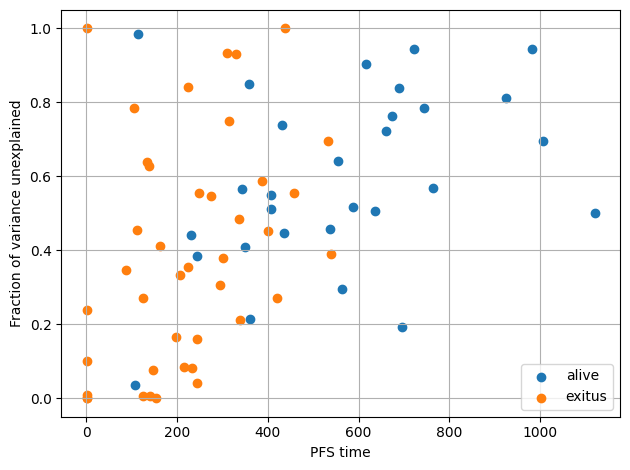

In [43]:
# FVU calculated using r2
patients_alive = patient_data_subset_param_fit_m2c.query('status=="Alive"')
patients_exitus = patient_data_subset_param_fit_m2c.query('status=="Exitus"')
plt.scatter(patients_alive.PFS_time_days, patients_alive.neut_fvu_r2, label='alive')
plt.scatter(patients_exitus.PFS_time_days, patients_exitus.neut_fvu_r2, label='exitus')
plt.legend()
plt.xlabel('PFS time')
plt.ylabel('Fraction of variance unexplained')
plt.grid()
plt.tight_layout()
plt.savefig('fig2_pfs.png', dpi=300)

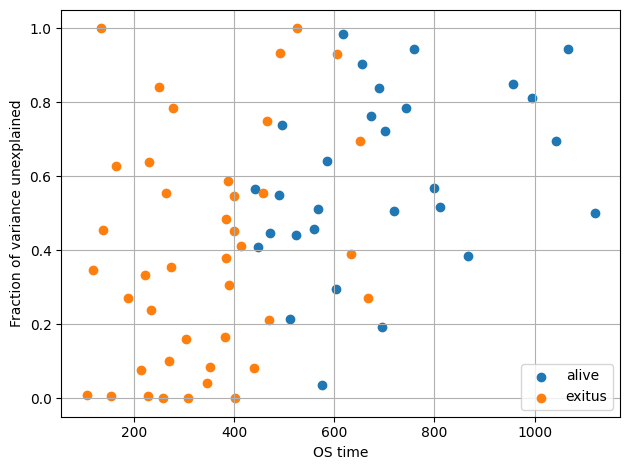

In [44]:
# FVU calculated using r2
patients_alive = patient_data_subset_param_fit_m2c.query('status=="Alive"')
patients_exitus = patient_data_subset_param_fit_m2c.query('status=="Exitus"')
plt.scatter(patients_alive.OS_time_ven2_days, patients_alive.neut_fvu_r2, label='alive')
plt.scatter(patients_exitus.OS_time_ven2_days, patients_exitus.neut_fvu_r2, label='exitus')
plt.legend()
plt.xlabel('OS time')
plt.ylabel('Fraction of variance unexplained')
plt.grid()
plt.tight_layout()
plt.savefig('fig2_os.png', dpi=300)

In [45]:
corrcoef, p = scipy.stats.pearsonr(patient_data_subset_param_fit_m2c.PFS_time_days, patient_data_subset_param_fit_m2c.neut_fvu_r2)
print(corrcoef, p)

0.4569185825051757 7.005536144689094e-05


In [46]:
corrcoef, p = scipy.stats.spearmanr(patient_data_subset_param_fit_m2c.PFS_time_days, patient_data_subset_param_fit_m2c.neut_fvu_r2)
print(corrcoef, p)

0.47602589650839916 3.112244080986476e-05


### Patient Outcomes and FVU

(0.0, 1.0)

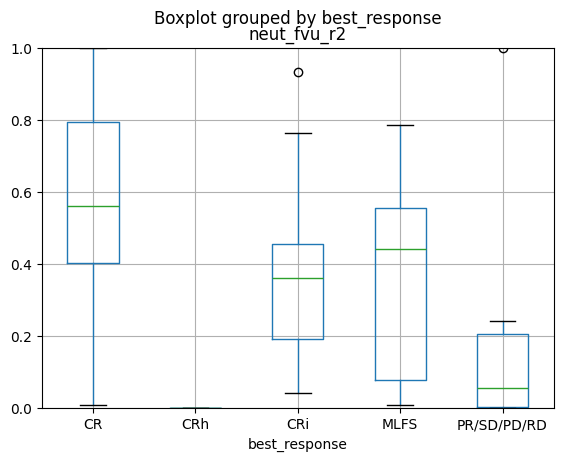

In [47]:
patient_data_subset_param_fit_m2c.boxplot("neut_fvu_r2", by='best_response')
plt.ylim(0, 1)

### Regression models

In [48]:
import statsmodels.api as sm

In [49]:
print(list(patient_data_subset_param_fit_m2c.columns))

['Study_subject_Id', 'incl_dg_for_tables', 'no_ven_therapy', 'prev_allo', 'prev_hypomet_all', 'Gender', 'age_group_scr', 'ecog_scr', 'hb_scr', 'leuk_scr', 'neut_all_scr', 'trom_scr', 'ld_scr', 'b_blasts_scr', 'blasts_bm_scr', 'fab', 'del_5', 'del_5q', 'del_7', 'del_7q', 'del_17p', 'complex', 'monosomal', 'HR_karyotype', 'karyotype_normal', 'NPM1', 'FLT3_tkd', 'FLT3_itd', 'FLT3_rat', 'CEBPA', 'DNMT3A', 'IDH1', 'IDH2', 'TET2', 'RUNX1', 'SRSF2', 'TP53', 'ASXL1', 'BCOR', 'CDKN2A', 'CREBBP', 'CUX1', 'EP300', 'ETV6', 'EZH2', 'GATA2', 'KDM6A', 'NF1', 'RAD21', 'SETD2', 'STAG2', 'XRSR2', 'BRAF', 'CALR', 'CBL', 'CSF3R', 'GATA1', 'JAK2', 'KIT', 'KRAS', 'NRAS', 'MPL', 'PDGFRA', 'PHF6', 'PTPN11', 'SETBP1', 'SF3B1', 'SMC1A', 'SMC3', 'U2AF1', 'WT1', 'c1_response', 'c2_response', 'c3_response', 'best_response', 'mrd_neg', 'mrd_method', 'relapse_occurred', 'eot_reason', 'eot_response', 'status', 'OS_time_ven2_days', 'PFS_time_days', 'ktr', 'gam', 'slope_ven_blast', 'slope_aza_blast', 'slope_ven_wbc', '

In [50]:
# create dummy variables for the best response groups
patient_data_subset_param_fit_m2c['age'] = patient_data_subset_param_fit_m2c.age_group_scr == '>75 years'
patient_data_subset_param_fit_m2c['is_pr_pd'] = patient_data_subset_param_fit_m2c.best_response == 'PR/SD/PD/RD'
patient_data_subset_param_fit_m2c['is_cr_mlfs'] = patient_data_subset_param_fit_m2c.best_response.isin(['CR', 'CRi', 'CRh', 'MLFS'])
patient_data_subset_param_fit_m2c['is_cr'] = patient_data_subset_param_fit_m2c.best_response.isin(['CR', 'CRi', 'CRh'])
patient_data_subset_param_fit_m2c['is_mlfs'] = (patient_data_subset_param_fit_m2c.best_response == 'MLFS')

### Regression models for all mutation features

In [51]:
blood_columns = ['ecog_scr', 'hb_scr', 'leuk_scr', 'neut_all_scr', 'trom_scr', 'ld_scr', 'b_blasts_scr']
gene_columns = [ 'del_5', 'del_5q', 'del_7', 'del_7q', 'del_17p', 'complex', 'monosomal', 'HR_karyotype', 'karyotype_normal', 'NPM1', 'FLT3_tkd', 'FLT3_itd', 'CEBPA', 'DNMT3A', 'IDH1', 'IDH2', 'TET2', 'RUNX1', 'SRSF2', 'TP53', 'ASXL1', 'BCOR', 'CDKN2A', 'CREBBP', 'CUX1', 'EP300', 'ETV6', 'EZH2', 'GATA2', 'KDM6A', 'NF1', 'RAD21', 'SETD2', 'STAG2', 'XRSR2', 'BRAF', 'CALR', 'CBL', 'CSF3R', 'GATA1', 'JAK2', 'KIT', 'KRAS', 'NRAS', 'MPL', 'PDGFRA', 'PHF6', 'PTPN11', 'SETBP1', 'SF3B1', 'SMC1A', 'SMC3', 'U2AF1', 'WT1']


#### LASSO

In [52]:
a_prior_features = ['age', 'neut_all_scr'] + gene_columns
X = patient_data_subset_param_fit_m2c.loc[:, a_prior_features].copy()
for c in gene_columns:
    X[c] = X[c].map(dict(Yes=1, No=0))
X = X.astype(float)
y = patient_data_subset_param_fit_m2c.neut_fvu_r2
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit_regularized(method='sqrt_lasso', alpha=1)
print(results.params.sort_values())

ETV6               -2.623146e-01
BRAF               -2.156996e-01
CUX1               -1.889398e-01
IDH1               -1.688625e-01
NRAS               -1.458501e-01
CREBBP             -1.402433e-01
SMC3               -1.297627e-01
complex            -9.054798e-02
PTPN11             -8.466855e-02
NPM1               -8.437537e-02
monosomal          -7.224531e-02
U2AF1              -6.596744e-02
SF3B1              -6.103928e-02
SRSF2              -5.580581e-02
FLT3_itd           -5.485007e-02
KRAS               -3.981949e-02
RUNX1              -2.391251e-02
EP300              -1.113656e-07
KIT                -1.048399e-07
del_5              -1.005527e-07
IDH2               -5.198252e-08
GATA2              -4.672803e-08
CSF3R              -4.078796e-08
FLT3_tkd           -3.734134e-08
CALR               -3.384449e-08
WT1                -2.819033e-08
CBL                -2.558414e-08
BCOR               -1.987005e-08
TET2               -1.727532e-08
del_17p            -1.628321e-08
MPL       

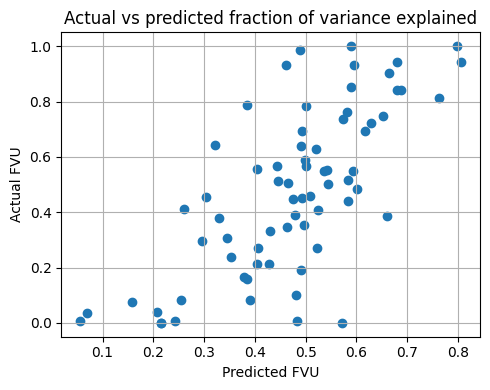

In [53]:
fig, ax = plt.subplots(figsize=(5, 4))
ax.scatter(results.fittedvalues, y)
ax.set_ylabel('Actual FVU')
ax.set_xlabel('Predicted FVU')
ax.grid()
ax.set_title('Actual vs predicted fraction of variance explained')
plt.tight_layout()
plt.savefig('fig2_fvu_predicted_vs_actual_lasso.png', dpi=300)

In [54]:
print(scipy.stats.pearsonr(results.fittedvalues, y))

PearsonRResult(statistic=0.7113700218761743, pvalue=5.145547500732764e-12)


In [55]:
top_params = results.params[(results.params > 0.1) | (results.params < -0.1)]
top_params = top_params.sort_values()
top_params = top_params[top_params.index != 'const']

In [56]:
top_params

ETV6           -0.262315
BRAF           -0.215700
CUX1           -0.188940
IDH1           -0.168863
NRAS           -0.145850
CREBBP         -0.140243
SMC3           -0.129763
del_5q          0.126163
HR_karyotype    0.144121
NF1             0.155930
DNMT3A          0.172973
dtype: float64

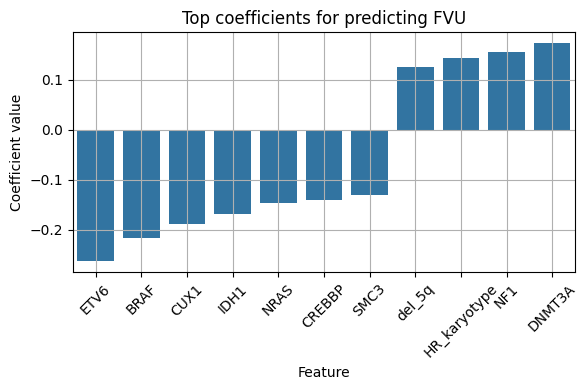

In [57]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.barplot(x=top_params.index, y=top_params, ax=ax)
plt.grid()
ax.tick_params(axis='x', rotation=45)
ax.set_xlabel('Feature')
ax.set_ylabel('Coefficient value')
plt.title('Top coefficients for predicting FVU')
plt.tight_layout()
plt.savefig('fig2_regression_coefficients.png', dpi=300)

#### All mutation features individually

In [58]:
gene_results = {}
for gene in gene_columns:
    gene_small_columns = [gene]
    a_prior_features = ['age', 'neut_all_scr'] + gene_small_columns
    X = patient_data_subset_param_fit_m2c.loc[:, a_prior_features].copy()
    for c in gene_small_columns:
        X[c] = X[c].map(dict(Yes=1, No=0))
    X = X.astype(float)
    y = patient_data_subset_param_fit_m2c.neut_fvu_r2
    X = sm.add_constant(X)
    model = sm.OLS(y, X)
    results = model.fit()
    gene_results[gene] = {'rsquared': results.rsquared, 'rsquared_adj': results.rsquared_adj,
                          'f_pvalue': results.f_pvalue, 'coef': results.params[gene],
                          'coef_pvalue': results.pvalues[gene], 'intercept': results.params['const'],
                          'age_coef': results.params['age'], 'neut_coef': results.params['neut_all_scr']}


In [59]:
gene_results_df = pd.DataFrame(gene_results).T
gene_results_df.sort_values('coef_pvalue')

,rsquared,rsquared_adj,f_pvalue,coef,coef_pvalue,intercept,age_coef,neut_coef
DNMT3A,0.078978,0.037114,0.140413,0.173034,0.020673,0.411694,0.001949,0.001925
ETV6,0.069917,0.027640,0.185499,-0.468138,0.029939,0.478837,0.022074,0.003530
CBL,0.069517,0.027222,0.187760,-0.470374,0.030434,0.492930,-0.010512,-0.000234
CUX1,0.064686,0.022172,0.217098,-0.295660,0.037109,0.486799,0.034784,-0.001450
NRAS,0.045303,0.001908,0.379034,-0.196900,0.083173,0.492310,0.004584,0.005118
del_7,0.042636,-0.000881,0.407735,0.368449,0.093154,0.447122,0.030635,0.009196
SMC3,0.040780,-0.002821,0.428714,-0.511368,0.100845,0.468602,0.006814,0.013931
SETBP1,0.037864,-0.005869,0.463359,0.483188,0.114329,0.455952,0.023387,0.005996
BRAF,0.037775,-0.005963,0.464451,-0.482310,0.114771,0.479237,0.001366,0.003438
PTPN11,0.037753,-0.005986,0.464723,-0.249051,0.114881,0.475920,0.011385,0.011785


#### Top individual mutation features

In [60]:
gene_small_columns = ['DNMT3A', 'ETV6', 'CBL', 'CUX1', 'NRAS', 'del_7']
a_prior_features = ['age', 'neut_all_scr'] + gene_small_columns
X = patient_data_subset_param_fit_m2c.loc[:, a_prior_features].copy()
for c in gene_small_columns:
    X[c] = X[c].map(dict(Yes=1, No=0))
X = X.astype(float)
y = patient_data_subset_param_fit_m2c.neut_fvu_r2
X = sm.add_constant(X)
model = sm.OLS(y, X)#sm.RLM(y, X, M=sm.robust.norms.HuberT())
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            neut_fvu_r2   R-squared:                       0.271
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                     2.830
Date:                Wed, 14 May 2025   Prob (F-statistic):            0.00974
Time:                        21:06:51   Log-Likelihood:                -2.9421
No. Observations:                  70   AIC:                             23.88
Df Residuals:                      61   BIC:                             44.12
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.4542      0.057      7.964   

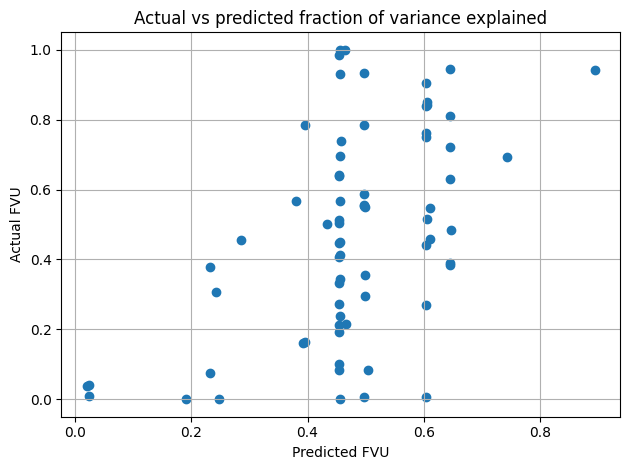

In [61]:
plt.scatter(results.fittedvalues, y)
plt.ylabel('Actual FVU')
plt.xlabel('Predicted FVU')
plt.grid()
plt.title('Actual vs predicted fraction of variance explained')
plt.tight_layout()

In [62]:
gene_small_columns = ['DNMT3A', 'ETV6', 'CUX1', 'NRAS', 'del_7', 'SMC3', 'TP53']
a_prior_features = [] + gene_small_columns
X = patient_data_subset_param_fit_m2c.loc[:, a_prior_features].copy()
for c in gene_small_columns:
    X[c] = X[c].map(dict(Yes=1, No=0))
X = X.astype(float)
y = patient_data_subset_param_fit_m2c.neut_fvu_r2
X = sm.add_constant(X)
model = sm.OLS(y, X)#sm.RLM(y, X, M=sm.robust.norms.HuberT())
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            neut_fvu_r2   R-squared:                       0.306
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     3.904
Date:                Wed, 14 May 2025   Prob (F-statistic):            0.00139
Time:                        21:06:51   Log-Likelihood:                -1.2065
No. Observations:                  70   AIC:                             18.41
Df Residuals:                      62   BIC:                             36.40
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4552      0.044     10.287      0.0

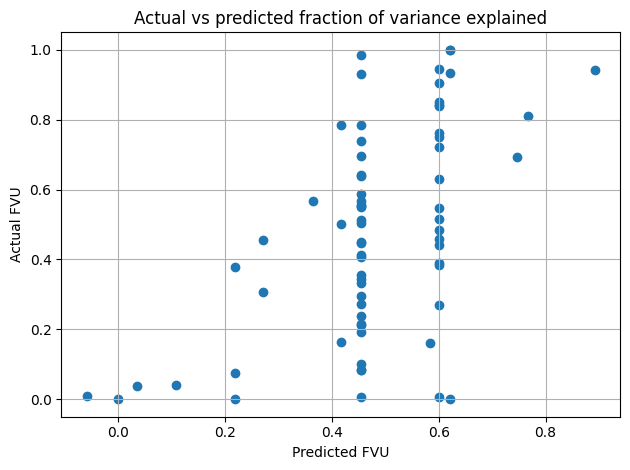

In [63]:
plt.scatter(results.fittedvalues, y)
plt.ylabel('Actual FVU')
plt.xlabel('Predicted FVU')
plt.grid()
plt.title('Actual vs predicted fraction of variance explained')
plt.tight_layout()
#plt.savefig('fig3_fvu_prediction.png', dpi=300)

#### Top features from LASSO

This includes all features identified that have a lasso coefficient of at least 0.1 or less than -0.1.

In [64]:
# using the top/bottom features identified via lassos
gene_small_columns = ['DNMT3A', 'NF1', 'HR_karyotype', 'del_5q', 'ETV6', 'BRAF', 'CUX1', 'IDH1', 'NRAS', 'CREBBP', 'SMC3']
a_prior_features = [] + gene_small_columns
X = patient_data_subset_param_fit_m2c.loc[:, a_prior_features].copy()
for c in gene_small_columns:
    X[c] = X[c].map(dict(Yes=1, No=0))
X = X.astype(float)
y = patient_data_subset_param_fit_m2c.neut_fvu_r2
X = sm.add_constant(X)
model = sm.OLS(y, X)#sm.RLM(y, X, M=sm.robust.norms.HuberT())
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            neut_fvu_r2   R-squared:                       0.397
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                     3.472
Date:                Wed, 14 May 2025   Prob (F-statistic):           0.000923
Time:                        21:06:52   Log-Likelihood:                 3.7170
No. Observations:                  70   AIC:                             16.57
Df Residuals:                      58   BIC:                             43.55
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.4619      0.046     10.000   

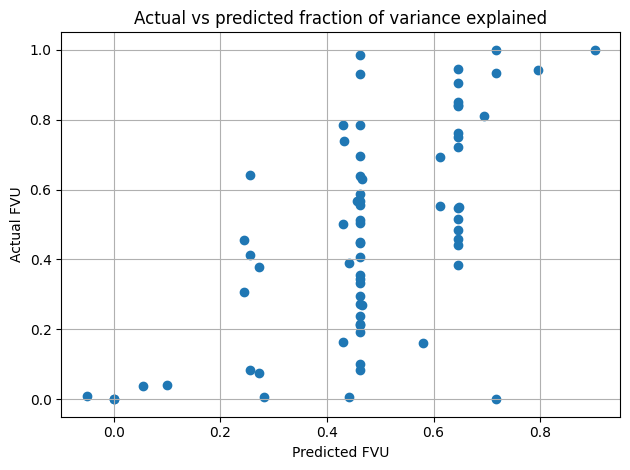

In [65]:
plt.scatter(results.fittedvalues, y)
plt.ylabel('Actual FVU')
plt.xlabel('Predicted FVU')
plt.grid()
plt.title('Actual vs predicted fraction of variance explained')
plt.tight_layout()
plt.savefig('fig3_fvu_prediction.png', dpi=300)

## 6. Model parameter correlations with patient outcomes

slope_ven_blast 0.34264786997464686 0.0036886238533694916
slope_aza_blast -0.08118324631514705 0.5040685616364822
slope_ven_wbc -0.03363761108127459 0.7822076136784251
slope_aza_wbc 0.16001096987368638 0.18577336324746774


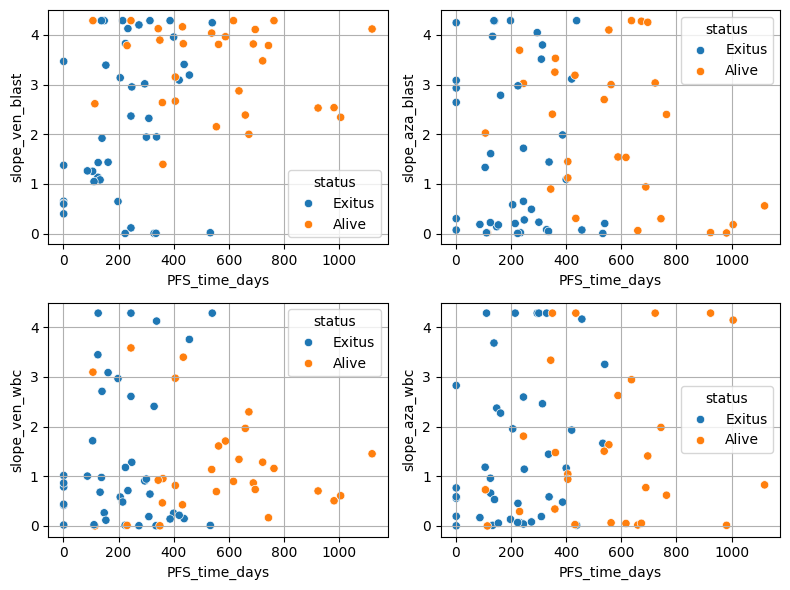

In [66]:
# add PFS here, OS, mutations
params = ['slope_ven_blast', 'slope_aza_blast', 'slope_ven_wbc', 'slope_aza_wbc']
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes = axes.flatten()
for ax, param in zip(axes, params):
    corrcoef, p = scipy.stats.pearsonr(patient_data_subset_param_fit_m2c.PFS_time_days, patient_data_subset_param_fit_m2c[param])
    print(param, corrcoef, p)
    sns.scatterplot(patient_data_subset_param_fit_m2c, x='PFS_time_days', y=param, ax=ax, hue='status')
    ax.grid()
plt.tight_layout()
plt.savefig('fig2_parameters_vs_pfs_slopes.png', dpi=300)

slope_ven_blast 0.32517591484304875 0.006019707923353728
slope_aza_blast -0.016770446923198568 0.890402536966491
slope_ven_wbc -0.005787056204833598 0.962077615529985
slope_aza_wbc 0.09689858954757109 0.4248735646157364


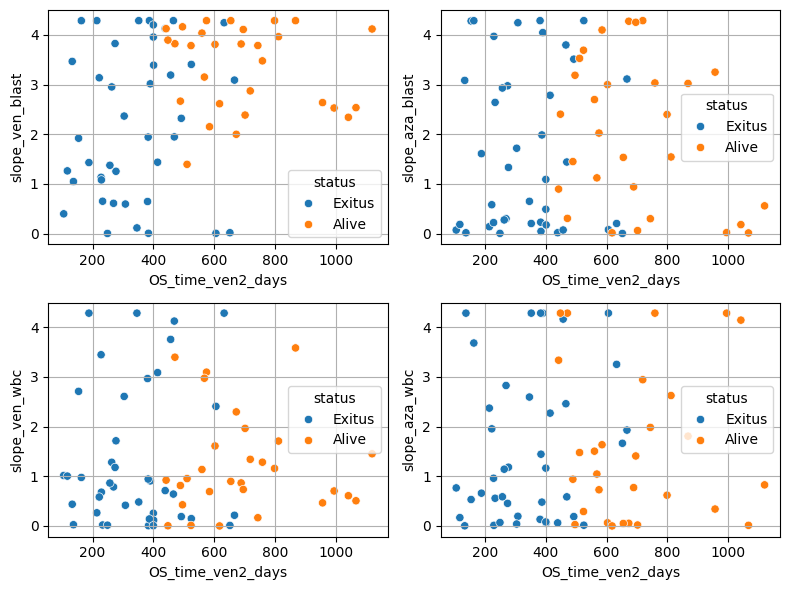

In [67]:
# add PFS here, OS, mutations
params = ['slope_ven_blast', 'slope_aza_blast', 'slope_ven_wbc', 'slope_aza_wbc']
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes = axes.flatten()
for ax, param in zip(axes, params):
    corrcoef, p = scipy.stats.pearsonr(patient_data_subset_param_fit_m2c.OS_time_ven2_days, patient_data_subset_param_fit_m2c[param])
    print(param, corrcoef, p)
    sns.scatterplot(patient_data_subset_param_fit_m2c, x='OS_time_ven2_days', y=param, ax=ax, hue='status')
    ax.grid()
plt.tight_layout()
plt.savefig('fig2_parameters_vs_os_slopes.png', dpi=300)

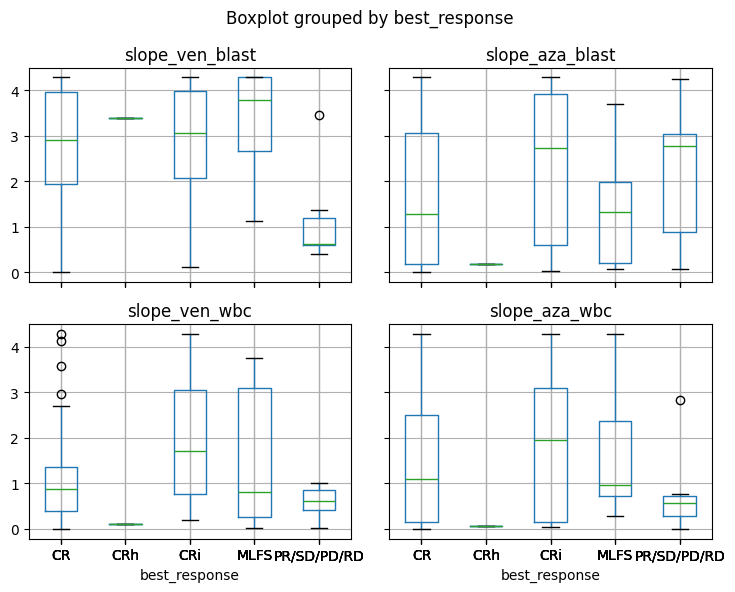

In [68]:
axes = patient_data_subset_param_fit_m2c.boxplot(by="best_response",
                                           column=['slope_ven_blast', 'slope_aza_blast', 'slope_ven_wbc', 'slope_aza_wbc'],
                                           layout=(2,2),
                                   figsize=(7.5,6))
plt.tight_layout()
plt.savefig('fig_supp_param_best_response.png', dpi=300)

In [69]:
pd.crosstab(patient_data_subset_param_fit_m2c.best_response, patient_data_subset_param_fit_m2c.status)

status,Alive,Exitus
best_response,,
CR,23,17
CRh,0,1
CRi,3,11
MLFS,3,6
PR/SD/PD/RD,0,6


## 7. Predicting model parameters using patient features

In [70]:
all_param_results = {}
for param in m2c_param_data.columns:
    gene_param_results = {}
    for gene in gene_columns:
        gene_small_columns = [gene]
        a_prior_features = ['age', 'neut_all_scr'] + gene_small_columns
        X = patient_data_subset_param_fit_m2c.loc[:, a_prior_features].copy()
        for c in gene_small_columns:
            X[c] = X[c].map(dict(Yes=1, No=0))
        X = X.astype(float)
        y = patient_data_subset_param_fit_m2c[param]
        X = sm.add_constant(X)
        model = sm.OLS(y, X)
        results = model.fit()
        gene_param_results[gene] = {'rsquared': results.rsquared, 'rsquared_adj': results.rsquared_adj,
                          'f_pvalue': results.f_pvalue, 'coef': results.params[gene],
                          'coef_pvalue': results.pvalues[gene], 'intercept': results.params['const'],
                          'age_coef': results.params['age'], 'neut_coef': results.params['neut_all_scr']}
        all_param_results[param, gene] = gene_param_results[gene]

In [71]:
all_param_results_df = pd.DataFrame(all_param_results).T


In [72]:
for param in m2c_param_data.columns:
    param_results_df = all_param_results_df.xs(param, level=0)
    print(param)
    top_rows = param_results_df.sort_values('coef_pvalue').head(6)
    print(top_rows)
    print(top_rows.index)

ktr
         rsquared  rsquared_adj  f_pvalue      coef  coef_pvalue  intercept  \
SMC3     0.063582      0.021018  0.224349  0.410694     0.069932   0.274339   
SF3B1    0.063036      0.020446  0.228018 -0.207846     0.071581   0.279979   
GATA2    0.062876      0.020279  0.229103  0.400029     0.072071   0.264401   
RAD21    0.052605      0.009542  0.308858 -0.253597     0.112325   0.288160   
del_17p  0.051256      0.008132  0.320927  0.180255     0.119184   0.270035   
ETV6     0.042441     -0.001085  0.409902 -0.214462     0.177058   0.279568   

         age_coef  neut_coef  
SMC3     0.062455  -0.005983  
SF3B1    0.058309   0.009275  
GATA2    0.067707   0.003494  
RAD21    0.046002  -0.000661  
del_17p  0.058213  -0.004550  
ETV6     0.062829   0.001543  
Index(['SMC3', 'SF3B1', 'GATA2', 'RAD21', 'del_17p', 'ETV6'], dtype='object')
gam
                  rsquared  rsquared_adj  f_pvalue      coef  coef_pvalue  \
FLT3_itd          0.096075      0.054987  0.081511 -0.335387     0

## 8. Model hypotheses

Hypothesis 1, hypothesis 2 - correlations with FVU values

In [73]:
neut_blast_correlations = pd.read_csv('../neut_blast_treatment_correlations.csv', index_col=0)

In [74]:
neut_blast_correlations = pd.read_csv('neut_blast_treatment_correlations_2025_05_09.csv', index_col=0)

### Adding hypothesis data to tables

In [75]:
#h1 = neut_blast_correlations.query('neut_treatment_spearmanr > 0.01')
#h2 = neut_blast_correlations.query('neut_blast_spearmanr < 0.01')
#h1 = neut_blast_correlations.query('neut_post_treatment_corr > 0')
#h2 = neut_blast_correlations.query('neut_blast_corr < 0')

In [76]:
m1b_rmse_merged = pd.concat([m1b_rmse_data, neut_blast_correlations], axis=1)
m4a_rmse_merged = pd.concat([m4a_rmse_data, neut_blast_correlations], axis=1)
m4b_rmse_merged = pd.concat([m4b_rmse_data, neut_blast_correlations], axis=1)
m4b_wbc_only_rmse_merged = pd.concat([m4b_wbc_only_rmse_data, neut_blast_correlations], axis=1)
m4c_rmse_merged = pd.concat([m4c_rmse_data, neut_blast_correlations], axis=1)

m2a_rmse_merged = pd.concat([m2a_rmse_data, neut_blast_correlations], axis=1)
m2b_rmse_merged = pd.concat([m2b_rmse_data, neut_blast_correlations], axis=1)
m2c_rmse_merged = pd.concat([m2c_rmse_data, neut_blast_correlations], axis=1)
m2d_rmse_merged = pd.concat([m2d_rmse_data, neut_blast_correlations], axis=1)
m2b_wbc_only_rmse_merged = pd.concat([m2b_wbc_only_rmse_data, neut_blast_correlations], axis=1)

In [77]:
rmse_data_combined = pd.concat([m1b_rmse_merged, m4a_rmse_merged, m4b_rmse_merged, m4b_wbc_only_rmse_merged, m4c_rmse_merged,
                                m2a_rmse_merged, m2b_rmse_merged, m2c_rmse_merged, m2d_rmse_merged, m2b_wbc_only_rmse_merged])

In [78]:
rmse_data_combined['h1'] = (rmse_data_combined.neut_treatment_spearmanr > 0.01)
rmse_data_combined['h2'] = (rmse_data_combined.neut_blast_spearmanr < -0.01)

### FVU vs H1 and H2 for all models

/tmp/ipykernel_4879/1006874083.py:6: UserWarning:

When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.

/tmp/ipykernel_4879/1006874083.py:11: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipykernel_4879/1006874083.py:12: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipykernel_4879/1006874083.py:13: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipykernel_4879/

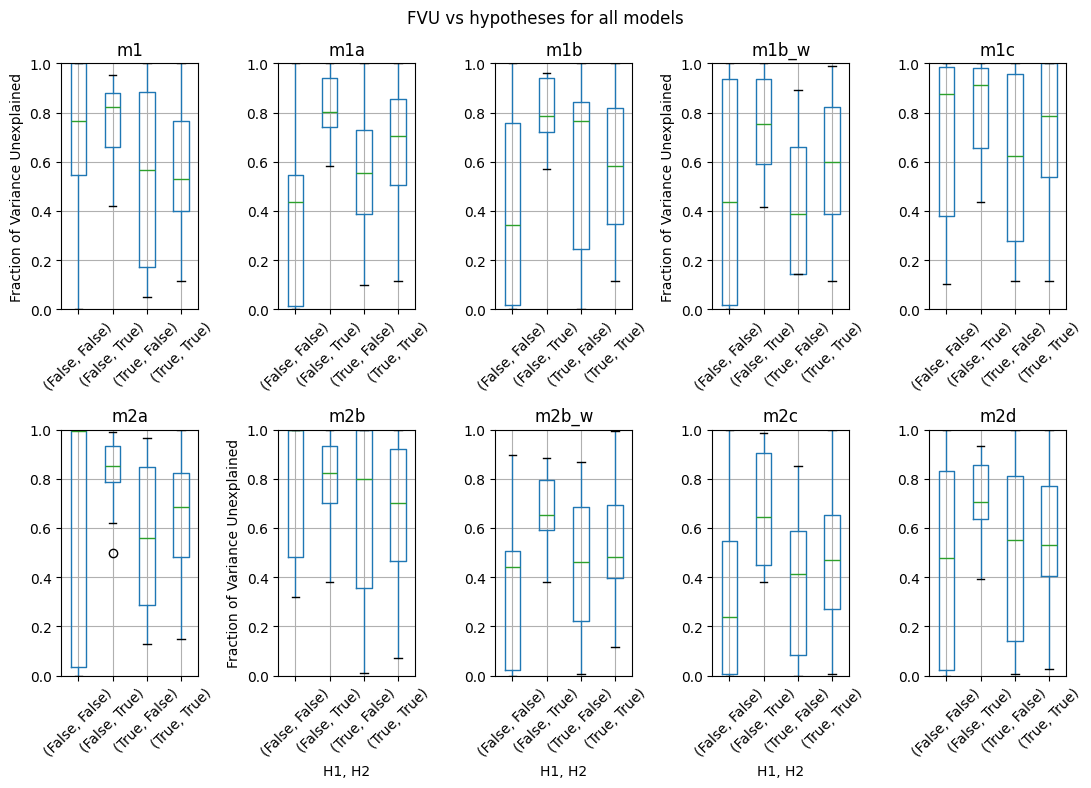

In [79]:
# TODO:
fig, axes = plt.subplots(2, 5, figsize=(11, 8))
#fig.delaxes(axes[1, 3])
axes = axes.flatten()
#axes = axes[:-1]
axes = rmse_data_combined.groupby('model').boxplot(column='neut_fvu_r2', by=['h1', 'h2'], ax=axes)
for ax in axes:
    ax.set_ylim(0, 1)
    ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel('')
axes[0].set_ylabel('Fraction of Variance Unexplained')
axes[3].set_ylabel('Fraction of Variance Unexplained')
axes[6].set_ylabel('Fraction of Variance Unexplained')
axes[6].set_xlabel('H1, H2')
axes[7].set_xlabel('H1, H2')
axes[8].set_xlabel('H1, H2')

fig.suptitle('FVU vs hypotheses for all models')
plt.tight_layout()
plt.savefig('fig2_all_errors.png', dpi=300)

In [80]:
rmse_data_combined['h1_h2'] = ['False, False']*len(rmse_data_combined)
rmse_data_combined.loc[rmse_data_combined.eval('h1 & ~h2'), 'h1_h2'] = 'True, False'
rmse_data_combined.loc[rmse_data_combined.eval('h1 & h2'), 'h1_h2'] = 'True, True'
rmse_data_combined.loc[rmse_data_combined.eval('~h1 & h2'), 'h1_h2'] = 'False, True'


<Axes: title={'center': 'neut_fvu_r2'}, xlabel='model'>

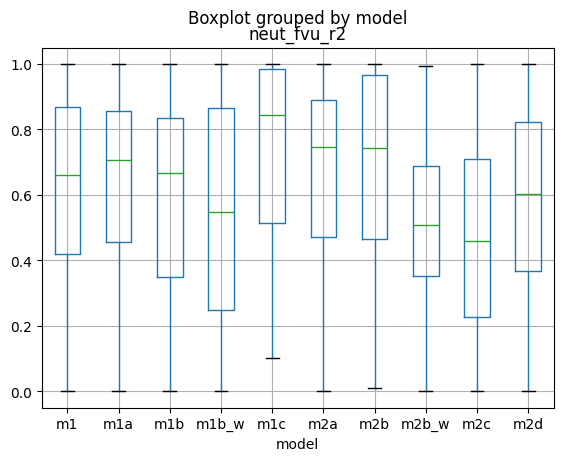

In [81]:
rmse_data_combined.boxplot(column='neut_fvu_r2', by='model')

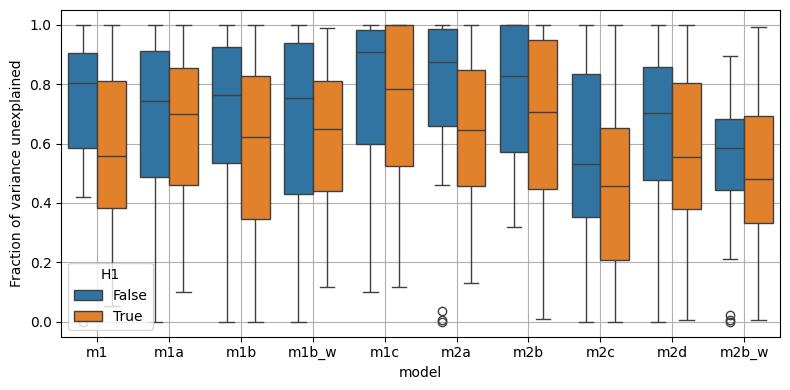

In [82]:
# TODO: do a different grouping for this - group by models, use a hue for the thing
fig, ax = plt.subplots(figsize=(8, 4))
sns.boxplot(data=rmse_data_combined.reset_index(), x='model', y='neut_fvu_r2', hue='h1', ax=ax)
ax.set_ylabel('Fraction of variance unexplained')
#ax.set_title('FVU for hypothesis 1')
# set 
ax.grid()
ax.legend(title='H1', loc='lower left')
plt.tight_layout()
plt.savefig('fig2_model_hypothesis_1_fvu.png', dpi=300)
plt.show()

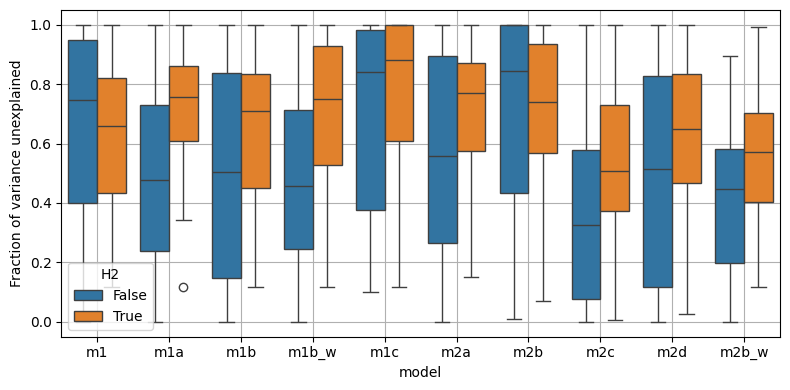

In [83]:
# TODO: do a different grouping for this - group by models, use a hue for the thing
fig, ax = plt.subplots(figsize=(8, 4))
sns.boxplot(data=rmse_data_combined.reset_index(), x='model', y='neut_fvu_r2', hue='h2', ax=ax)
ax.set_ylabel('Fraction of variance unexplained')
#ax.set_title('FVU for hypothesis 2')
ax.legend(title='H2', loc='lower left')
ax.grid()
plt.tight_layout()
plt.savefig('fig2_model_hypothesis_2_fvu.png', dpi=300)
plt.show()

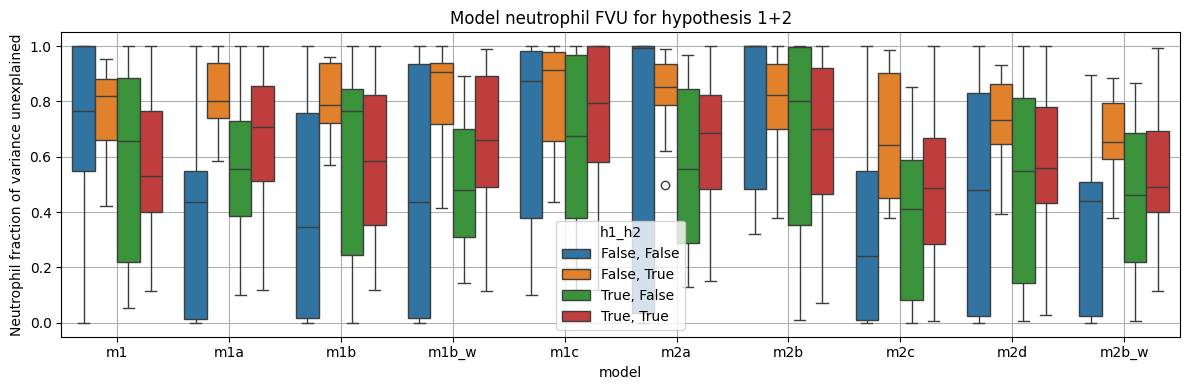

In [85]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.boxplot(data=rmse_data_combined.reset_index(), x='model', y='neut_fvu_r2', hue='h1_h2', ax=ax,
            hue_order=['False, False', 'False, True', 'True, False', 'True, True'])
ax.set_ylabel('Neutrophil fraction of variance unexplained')
ax.set_title('Model neutrophil FVU for hypothesis 1+2')
ax.grid()
plt.tight_layout()
plt.savefig('fig2_model_hypothesis_1_2_fvu.png', dpi=300)
plt.show()

### Statistical hypothesis testing for H1

In [86]:
for model in rmse_data_combined.model.unique():
    print(model, scipy.stats.ranksums(rmse_data_combined.query(f'model=="{model}" and h1==True').neut_fvu_r2,
                     rmse_data_combined.query(f'model=="{model}" and h1==False').neut_fvu_r2))

m1 RanksumsResult(statistic=-2.5241260113576187, pvalue=0.011598634449035233)
nan RanksumsResult(statistic=nan, pvalue=nan)
m1a RanksumsResult(statistic=-0.6341400324100421, pvalue=0.5259894390505462)
m1b RanksumsResult(statistic=-1.0817682905818367, pvalue=0.2793554998399834)
m1b_w RanksumsResult(statistic=-1.5169624304710811, pvalue=0.1292761697373253)
m1c RanksumsResult(statistic=-0.8206518066482898, pvalue=0.4118446292938597)
m2a RanksumsResult(statistic=-2.4495213016623194, pvalue=0.01430462482845461)
m2b RanksumsResult(statistic=-1.4299236024932322, pvalue=0.15273894705097582)
m2c RanksumsResult(statistic=-1.2247606508311597, pvalue=0.22066541480154)
m2d RanksumsResult(statistic=-0.7149618012466161, pvalue=0.4746326471969664)
m2b_w RanksumsResult(statistic=-0.9449929894737883, pvalue=0.34466245512879223)


/home/yzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/scipy/stats/_stats_py.py:9205: RuntimeWarning:

invalid value encountered in scalar divide



In [87]:
for model in rmse_data_combined.model.unique():
    print(model, scipy.stats.ranksums(rmse_data_combined.query(f'model=="{model}" and h2==True').neut_fvu_r2,
                     rmse_data_combined.query(f'model=="{model}" and h2==False').neut_fvu_r2))

m1 RanksumsResult(statistic=-0.17902871850985821, pvalue=0.857915151865571)
nan RanksumsResult(statistic=nan, pvalue=nan)
m1a RanksumsResult(statistic=2.5302725549393297, pvalue=0.011397395258718341)
m1b RanksumsResult(statistic=0.94288458415192, pvalue=0.3457399408602775)
m1b_w RanksumsResult(statistic=1.9991540233600835, pvalue=0.045591691402054164)
m1c RanksumsResult(statistic=1.611258466588724, pvalue=0.10712339925384028)
m2a RanksumsResult(statistic=1.2293305337676932, pvalue=0.21894790365771588)
m2b RanksumsResult(statistic=-0.5251509076289175, pvalue=0.5994782891608139)
m2c RanksumsResult(statistic=1.9156072880554829, pvalue=0.05541510120205831)
m2d RanksumsResult(statistic=1.0861075589598066, pvalue=0.2774314084913646)
m2b_w RanksumsResult(statistic=1.945445407807126, pvalue=0.05172139416210965)


/home/yzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/scipy/stats/_stats_py.py:9205: RuntimeWarning:

invalid value encountered in scalar divide

